# Modelo General del RIT - David

In [2]:
import pandas as pd
import numpy as np
import utils as ut # esta librería tiene funciones para poder obtener un procesamiento del <T,H>
import spacy

## Empezaremos con cargar los words embeddings de GLOVE
### Se pueden cambiar por los que sean necesarios

In [3]:
nlp = spacy.load("en_core_web_md") # modelo de nlp

In [4]:
ut.load_vectors_in_lang(nlp,"data/glove.840B.300d.txt") # carga de vectores en nlp.wv

## Lectura de los pares <T,H> para realizar las pruebas
### se cargará la información de los textos e hipótesis en listas

In [5]:
prueba=pd.read_csv("data/prueba.csv")  # archivo donde se tiene almacenado la información de los pares <T,H>
prueba

,Unnamed: 0,Unnamed: 0.1,gold_label,sentence1,sentence2,SET
0,568111,558275,entailment,"A man wearing a blue shirt, black apron, eyegl...",A person in appropriate institution protection...,TEST
1,568812,558976,entailment,A man dressed in a red shirt and black tie sta...,a guy in a red top and tie makes a speech,TEST
2,560781,550939,contradiction,A young boy runs across a road in front of a s...,A boy sleeps in his bed.,TEST
3,565799,555963,contradiction,An Asian woman is standing on a path with a ba...,Nobody is standing,TEST
4,562665,552829,neutral,A child in a maroon shirt playing next to a fo...,The child is getting wet from the fountain.,TEST
...,...,...,...,...,...,...
95,567068,557232,entailment,"A group of men in blue shirts, banded hats, an...",a bunch of guys in colorful clothes stand toge...,TEST
96,568650,558814,entailment,A woman holding a newborn baby.,woman holds baby,TEST
97,559485,549643,contradiction,A skateboarding youth does a trick on a rail.,A man painting a tree.,TEST
98,559755,549913,contradiction,Four children are playing in some water.,The children are doing chores.,TEST


In [6]:
textos = prueba["sentence1"].to_list()       # almacenamiento en listas
hipotesis = prueba["sentence2"].to_list()
print(textos)
print(hipotesis)

['A man wearing a blue shirt, black apron, eyeglasses, and a mask is handling food in a tray.', 'A man dressed in a red shirt and black tie stands up at a wedding reception to make a speech.', 'A young boy runs across a road in front of a sky blue building with barred windows.', 'An Asian woman is standing on a path with a basket on her head looking into a mirror she is holding in her hand.', 'A child in a maroon shirt playing next to a fountain.', 'man dressed in orange clothing with face covered seemingly balancing on a cane being held be a similarly dressed man sitting crossed legged on the ground at a shopping mall.', 'An old man with a package poses in front of an advertisement.', 'People dressed in traditional Japanese garb walk in a procession through a courtyard paved with paving stones.', 'Two children play in the snow by the side of the road.', 'Blond-haired girl wearing a bicycle helmet, a black t-shirt that reads "Twizzlers" and a printed dog tag necklace around her neck.',

## Procesamiento de todos los pares:
### Limpieza de los textos (eliminación de puntuación)
### Obtener su representación de embeddings normalizada
### Obtener su representación de embeddings no normalizada (esto para el calculo de la distancia euclideana)
### Generar matriz de producto puntos de vectores

In [23]:
import mutual_info as mi

from scipy.stats import wasserstein_distance

import conceptnet_lite
conceptnet_lite.connect("data/conceptnet.db")
from conceptnet_lite import Label, edges_for

In [33]:
## esta función revisa hiperonimia, sinonimia entre otras.
def encontrar_relaciones(relaciones):
    borrar=set()
    borrar_i=set()
    for r in relaciones:
        index=r[0]
        c=r[1]
        wt=str(index).split("{")[1].split(",")[0]
        wh=str(c).split("{")[1].split(",")[0]    
        try:
            for e in edges_for(Label.get(text=wh, language='en').concepts, same_language=True):
                if "synonym"==e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                    else:
                        if e.start.text==wt:
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                elif "is_a" ==e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            print(wh," is_a ",wt)
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                    else: ##quitar y la busqueda de relacioens
                        if wh== e.end.text:
                            if e.start.text==wt:
                                print(wt," is_a ",wh)
                                borrar.add(c)
                                borrar_i.add(index)
                                break
                # elif "derived_from" == e.relation.name:
                #     if wh== e.start.text:
                #         if e.end.text==wt:
                #             print(wh," derivado_from ",wt)
                #             borrar.add(c)
                #             borrar_i.add(index)
                #             break
                elif "used_for" == e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            print(wh," used_for ",wt)
                            borrar.add(c)
                            borrar_i.add(index)
                            break
        except:
            a=0
    return list(borrar),list(borrar_i)

In [34]:
def encontrar_relaciones_contrarias(relaciones):
    antonyms=[]
    borrar=[]
    borrar_i=[]
    for r in relaciones:
        index=r[0]
        c=r[1]
        wt=str(index).split("{")[1].split(",")[0]
        wh=str(c).split("{")[1].split(",")[0]
        try:
            for e in edges_for(Label.get(text=wh, language='en').concepts, same_language=True):
                if "antonym" ==e.relation.name:
                    if wt== e.start.text:
                        if e.end.text==wh:
                            print(wt," antonym ",wh)
                            #borrar.append(c)
                            #borrar_i.append(index)
                            antonyms.append(wt)
                            break
                        else:
                            print(wh," antonym ",wt)
                            #borrar.append(c)
                            #borrar_i.append(index)
                            antonyms.append(wt)
                            break
                elif "distinct_from" ==e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            print(wh," distinct from ",wt)
                            #borrar.append(c)
                            #borrar_i.append(index)
                            antonyms.append(wt)
                            break
                    else:
                        if e.start.text==wt:
                            print(wt," antonym ",wh)
                            #borrar.append(c)
                            #borrar_i.append(index)
                            antonyms.append(wt)
                            break
        except:
            a=0
    return borrar,borrar_i,antonyms

In [35]:
def encontrar_relaciones_cercanas(indexes,columnas):
    borrar=[]
    borrar_i=[]
    related=[]
    for index in indexes:
        for c in columnas:
            wt=str(index).split("{")[1].split(",")[0]
            wh=str(c).split("{")[1].split(",")[0]
            try:
                for e in edges_for(Label.get(text=wh, language='en').concepts, same_language=True):
                    if "related_to" ==e.relation.name:
                        if wt== e.start.text:
                            if e.end.text==wh:
                                print(wt," related_to ",wh)
                                #borrar.append(c)
                                #borrar_i.append(index)
                                related.append(wt)
                                break
                            else:
                                print(wh," related_to ",wt)
                                #borrar.append(c)
                                #borrar_i.append(index)
                                related.append(wt)
                                break
                    elif "similar_to" ==e.relation.name:
                        if wh== e.start.text:
                            if e.end.text==wt:
                                print(wh," similar_to ",wt)
                                #borrar.append(c)
                                #borrar_i.append(index)
                                related.append(wt)
                                break
                        else:
                            if e.start.text==wt:
                                print(wt," similar_to ",wh)
                                #borrar.append(c)
                                #borrar_i.append(index)
                                related.append(wt)
                                break
            except:
                a=0
    return borrar,borrar_i,related

In [36]:
def obtener_distancia(texto_v,hipotesis_v,texto_t,texto_h):
    lista_l=[]
    for i in range(len(texto_t)):
        lista=[]
        for j in range(len(texto_h)):
            lista.append(np.linalg.norm(texto_v[i] - hipotesis_v[j]))#*wasserstein_distance(texto_2[i],hipotesis_2[j]))
        lista_l.append(lista)
    df_distEuc=pd.DataFrame(lista_l,index=texto_t,columns=texto_h)
    col=df_distEuc.columns
    borrar=[]
    for c in col:
        if "{null" in str(c) or "{be,VERB" in str(c) or ("NOUN" not in str(c) and "VERB" not in str(c) and "ADJ" not in str(c) and "ADV" not in str(c)):
            borrar.append(c)        
    borrar_i=[]
    indexes=df_distEuc.index
    for index in indexes:
        if "{null" in str(index) or "{be,VERB" in str(index) or ("NOUN" not in str(index) and "VERB" not in str(index) and "ADJ" not in str(index) and "ADV" not in str(index)):
            borrar_i.append(index)        
    df_distEuc=df_distEuc.drop(borrar,axis=1)
    df_distEuc=df_distEuc.drop(borrar_i,axis=0)
    return df_distEuc.min().sum()

In [37]:
def wasserstein_mutual_inf(texto_v,hipotesis_v,texto_t,texto_h):  
    lista_l=[]
    lista_muinfor=[]   
    for i in range(len(texto_t)):
        lista=[]
        lista_mu=[]
        for j in range(len(texto_h)):
            lista.append(wasserstein_distance(texto_v[i],hipotesis_v[j]))
            lista_mu.append(mi.mutual_information_2d(np.array(texto_v[i]),np.array(hipotesis_v[j])))
        lista_l.append(lista)
        lista_muinfor.append(lista_mu)
    DFmearth=pd.DataFrame(lista_l,index=texto_t,columns=texto_h)
    DFmutual_inf=pd.DataFrame(lista_muinfor,index=texto_t,columns=texto_h)
    return DFmearth,DFmutual_inf

In [38]:
def entropia(X):
    """Devuelve el valor de entropia de una muestra de datos""" 
    probs = [np.mean(X == valor) for valor in set(X)]
    return -round(sum(p * np.log2(p) for p in probs), 3)

In [39]:
import time

# Proceso principal

In [40]:
sumas=[]
distancias=[]
entropias=[]
etiquetas=[]
mearts=[]
mutinf=[]
max_info=[]
list_antonimos=[]
listas_malign=[]
lista_anto=[]
lista_related=[]
lista_relatedT=[]

inicio = time.time()

for i in range(len(textos)):
#for i in range(1):
    t_vectors=ut.get_matrix_rep(textos[i],nlp,pos_to_remove=['PUNCT'], normed=False,lemmatize=False)
    h_vectors=ut.get_matrix_rep(hipotesis[i],nlp,pos_to_remove=['PUNCT'], normed=False,lemmatize=False)
    t_vectors_n=ut.get_matrix_rep(textos[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)
    h_vectors_n=ut.get_matrix_rep(hipotesis[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)
    t_clean=ut.get_words_rep(textos[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)
    h_clean=ut.get_words_rep(hipotesis[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)


    # Obtencion de matriz de alineamiento, matriz de move earth y mutual information
    ma=np.dot(t_vectors_n,h_vectors_n.T)
    print(len(t_vectors_n),len(h_vectors_n),len(t_clean),len(h_clean))
    m_earth,m_mi=wasserstein_mutual_inf(t_vectors_n,h_vectors_n,t_clean,h_clean)
    ma=pd.DataFrame(ma,index=t_clean,columns=h_clean)

    ###### BORRADO DE COSAS QUE NO OCUPO, SOLO NOS QUEDAMOS CON INFORMACIÓN DE TIPOS DE PALABRA: NOUN, VERB, ADJ Y ADV
    # TAMBIÉN OMITIMOS EL VERBO BE DEBIDO A QUE POR LO REGULAR SE UTILIZA COMO AUXILIAR Y ES UN VERBO COPULATIVO
    # sirve para construir la llamada predicación nominal del sujeto de una oración: 
    # #el sujeto se une con este verbo a un complemento obligatorio llamado atributo que por lo general determina 
    # alguna propiedad, estado o equivalencia del mismo, por ejemplo: "Este plato es bueno". "Juan está casado". 

    col=ma.columns
    borrar=[]
    indexes=ma.index
    for c in col:
        if "{null," in str(c) or "{be,VERB" in str(c) or ("NOUN" not in str(c) and "VERB" not in str(c) and "ADJ" not in str(c) and "ADV" not in str(c)):
            borrar.append(c)        
        elif str(c) in indexes:
            borrar.append(c)        
    borrar_i=[]
    for index in indexes:
        if "{null," in str(index) or "{be,VERB" in str(index) or ("NOUN" not in str(index) and "VERB" not in str(index) and "ADJ" not in str(index) and "ADV" not in str(index)):
            borrar_i.append(index) 
        elif str(index) in col:
            borrar_i.append(index) 
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)

    # ELIMINAMOS INFORMACIÓN DONDE SE CORRESPONDAN EN LEMMAS, TENGA UN PRODUCTO IGUAL A 1 Y SEAN IGUALES LOS INDICES Y COLUMNAS
    # SI EL VALOR ES IGUAL A 1 SIGNIFICA QUE ES LA MISMA PALABRA, O SON SINONIMOS
    borrar=[]
    borrar_i=[]
    col=ma.columns
    for index,strings in ma.iterrows():
        lema_i=str(index).split("{")[1].split(",")[0]
        for c in col:
            if index==c:
                borrar_i.append(index)
                borrar.append(c)
            if strings[c]>=1:
                borrar_i.append(index)
                borrar.append(c)
            lema_c=str(c).split("{")[1].split(",")[0]
            if lema_i == lema_c:
                borrar_i.append(index)
                borrar.append(c)
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)
    
    #primera vuelta ---------------------------------------------------------------------------------
    # #PARA REVISAR SI EXISTEN RELACIONES DE SIMILITUD SEMÁNTICA A TRAVÉS DEL USO DE CONCEPNET

    a=ma.idxmax().values
    b=ma.columns
    rel=[]
    for i in range(len(a)):
        rel.append((a[i],b[i]))
    borrar,borrar_i=encontrar_relaciones(rel[:])
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)

    # relaciones contrarias
    #PARA REVISAR SI EXISTEN RELACIONES CONTRARIAS A TRAVÉS DEL USO DE CONCEPNET
    a=ma.idxmax().values
    b=ma.columns
    rel=[]
    for i in range(len(a)):
        rel.append((a[i],b[i]))
    borrar,borrar_i,d=encontrar_relaciones_contrarias(rel[:])
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)

    # segunda vuelta--------------------------------------------------------------------------------------------
    # #PARA REVISAR SI EXISTEN RELACIONES DE SIMILITUD SEMÁNTICA A TRAVÉS DEL USO DE CONCEPNET
    a=ma.idxmax().values
    b=ma.columns
    rel=[]
    for i in range(len(a)):
        rel.append((a[i],b[i]))
    borrar,borrar_i=encontrar_relaciones(rel[:])
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)
        
    #relaciones contrarias quitar
    a=ma.idxmax().values
    b=ma.columns
    rel=[]
    for i in range(len(a)):
        rel.append((a[i],b[i]))
    
    borrar,borrar_i,d1=encontrar_relaciones_contrarias(rel[:])
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)

    # ultima VUELTA PARA CHECAR RELACIONES CERCANAS --------------------------------------------------
    # relaciones cercanas quitar
    indexes=ma.index
    columnas=ma.columns
    borrar,borrar_i,r_l2=encontrar_relaciones_cercanas(indexes,columnas)
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)

    #   ALMACENAMIENTO DE TODA LA INFORMACIÓN PROCESADA
    #alamacenado de resultados
    sumas.append(ma.min().sum())
    max_info.append((ma.max().sum()/(ma.shape[1])))
    entropias.append(entropia(ma.round(2).values.flatten()))
    mearts.append(m_earth.max().sum())
    mutinf.append(m_mi.max().sum())

    distancias.append(obtener_distancia(t_vectors,h_vectors,t_clean,h_clean)) 
    
    d2=[]   
    if d==[] and d1==[]:
        d2=[]
    else:
        d2=list(set(d+d1))
    r2=[]   
    if r_l2==[]:
        r2=[]
    else:
        r2=list(set(r_l2))
    list_antonimos.append(len(d2))
    listas_malign.append(ma)
    lista_anto.append(d2)
    lista_related.append(len(r2))
    lista_relatedT.append(r2)


fin = time.time()
print("Tiempo que se llevo:",round(fin-inicio,2)," segundos")

18 9 18 9
man  is_a  person
food  related_to  meal
20 11 20 11
guy  is_a  man
dress  related_to  top
17 6 17 6
24 3 24 3
11 8 11 8


/tmp/ipykernel_99283/1274647467.py:160: RuntimeWarning: invalid value encountered in double_scalars
  max_info.append((ma.max().sum()/(ma.shape[1])))


30 7 30 7
12 10 12 10
17 9 17 9
12 6 12 6
snow  is_a  weather
play  related_to  enjoy
23 9 23 9
11 6 11 6
18 6 18 6
father  is_a  man
lawn  is_a  grass
12 4 12 4
man  antonym  people
man  antonym  people
man  related_to  people
18 7 18 7
26 14 26 14
girl  is_a  child
12 8 12 8
22 6 22 6
5 8 5 8
water  related_to  lake
10 6 10 6
lady  is_a  woman
dog  antonym  cat
dog  antonym  cat
dog  related_to  cat
37 8 37 8
boy  is_a  child
14 6 14 6
26 6 26 6
8 5 8 5
9 7 9 7
9 4 9 4
24 8 24 8
shadow  related_to  light
12 5 12 5
ball  related_to  play
ball  related_to  game
11 8 11 8
pass  antonym  go
pass  antonym  go
pass  related_to  go
13 7 13 7
man  related_to  people
book  related_to  read
book  related_to  material
12 7 12 7
6 9 6 9
guy  is_a  man
12 6 12 6
child  antonym  adult
child  antonym  adult
child  related_to  adult
18 9 18 9
woman  is_a  man
8 6 8 6
celebrate  related_to  celebration
16 9 16 9
man  related_to  people
16 13 16 13
dress  related_to  girl
8 6 8 6
8 8 8 8
son  is_a  ch

In [41]:
clases=prueba["gold_label"].values
temp1 =np.array([sumas,distancias,entropias,mutinf,mearts,max_info,list_antonimos,lista_related,clases])
df_resultados = pd.DataFrame(temp1.T,columns=["suma","distancias","entropias","mutual_info","m_earth","max_info_p","antonimos","relaciones","CLASS"])
df_resultados

,suma,distancias,entropias,mutual_info,m_earth,max_info_p,antonimos,relaciones,CLASS
0,-0.264991,294.032,4.839,9.57686,0.0371929,0.517302,0,1,entailment
1,0.103484,189.136,2.585,1.78476,0.006869,0.251793,0,1,entailment
2,-0.00962379,123.245,3.948,3.90281,0.0173274,0.289142,0,0,contradiction
3,0,0,0,0,0,NaN,0,0,contradiction
4,0.176506,113.819,2.75,3.76301,0.0118327,0.373197,0,0,neutral
...,...,...,...,...,...,...,...,...,...
95,-0.0802919,247.618,4.438,7.50255,0.0352303,0.464188,0,1,entailment
96,0,37.5246,0,0,0,NaN,0,0,entailment
97,0.160267,189.692,3.64,5.41695,0.0268522,0.316492,0,1,contradiction
98,0.291853,97.5582,2,3.77399,0.0102693,0.363122,0,1,contradiction


In [42]:
df_resultados.to_csv("salida/resultadoMRIT1.csv",index=False)

<AxesSubplot:title={'center':'distancias'}, xlabel='CLASS'>

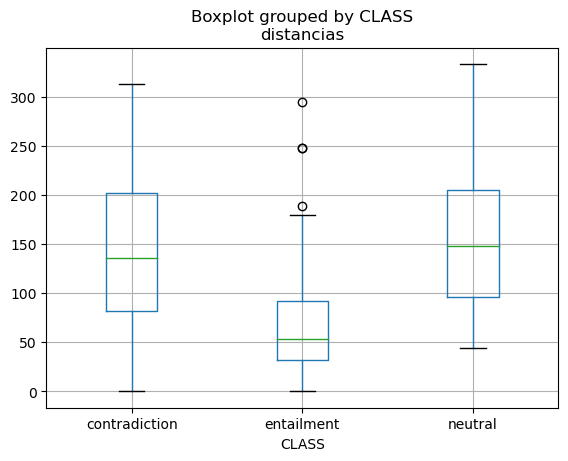

In [47]:
df_resultados.boxplot(by="CLASS",column=["distancias"])

array([<AxesSubplot:title={'center':'suma'}, xlabel='CLASS'>,
       <AxesSubplot:title={'center':'entropias'}, xlabel='CLASS'>],
      dtype=object)

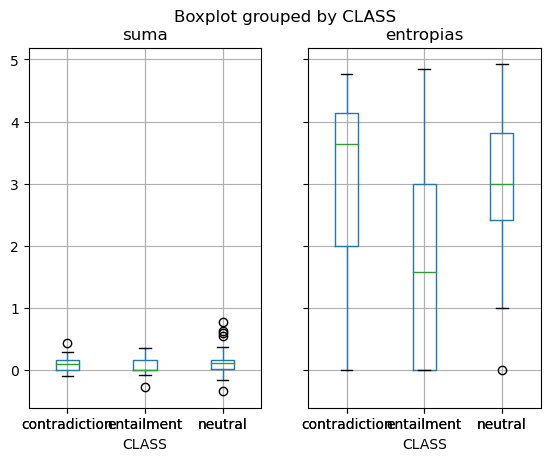

In [48]:
df_resultados.boxplot(by="CLASS",column=["suma","entropias"])

array([[<AxesSubplot:title={'center':'mutual_info'}, xlabel='CLASS'>,
        <AxesSubplot:title={'center':'m_earth'}, xlabel='CLASS'>],
       [<AxesSubplot:title={'center':'max_info_p'}, xlabel='CLASS'>,
        <AxesSubplot:>]], dtype=object)

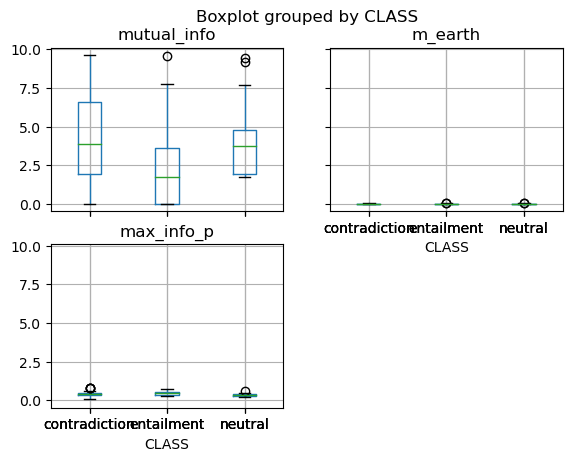

In [44]:
df_resultados.boxplot(by="CLASS",column=["mutual_info","m_earth","max_info_p"])

array([<AxesSubplot:title={'center':'antonimos'}, xlabel='CLASS'>,
       <AxesSubplot:title={'center':'relaciones'}, xlabel='CLASS'>],
      dtype=object)

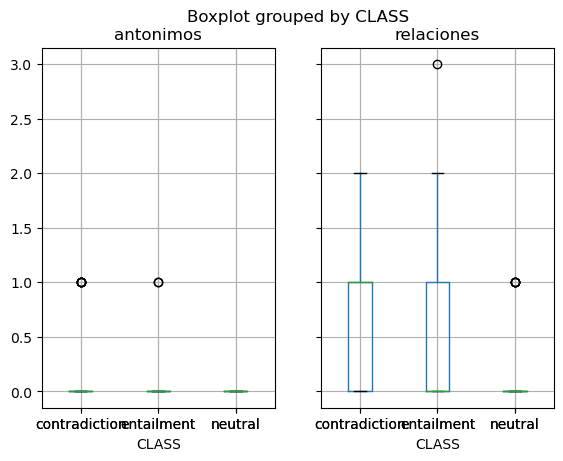

In [45]:
df_resultados.boxplot(by="CLASS",column=["antonimos","relaciones"])